# Práctica Final: Clasificación con Scikit-learn, MLflow y FastAPI

Este proyecto consta de dos partes:

**Parte 1:** Entrenamiento de un modelo de clasificación utilizando Scikit-learn, con registro de métricas usando MLflow.

**Parte 2:** Desarrollo de una API web con FastAPI que incluye endpoints básicos y dos módulos que utilizan Hugging Face.

A continuación se documenta todo el código utilizado junto con una breve explicación de cada etapa.


## 1. Exploración de Datos

Utilizamos el dataset `fetch_20newsgroups` de Scikit-learn, que contiene textos en inglés clasificados en 20 categorías. A continuación se muestra un análisis inicial de su contenido.


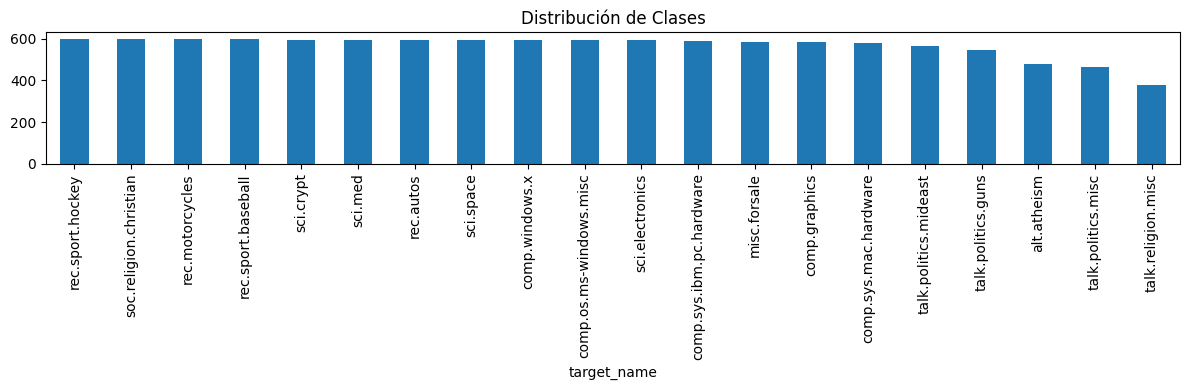

,text,target_name
2123,"Hi Xperts,\n\nthis is a repost (no one respond...",comp.windows.x
3866,\nI agree. Adding layers of managers and bure...,sci.med
0,I was wondering if anyone out there could enli...,rec.autos


In [1]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import matplotlib.pyplot as plt

data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame({'text': data.data, 'target': data.target})
df['target_name'] = df['target'].map(lambda x: data.target_names[x])

df['target_name'].value_counts().plot(kind='bar', figsize=(12,4), title='Distribución de Clases')
plt.tight_layout()
plt.show()

df[['text', 'target_name']].sample(3)


## 2. Preprocesamiento de Texto

Creamos funciones en `utils.py` para limpiar los textos y vectorizarlos con `TfidfVectorizer`.


In [ ]:
# utils.py
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def prepare_data(data, target, test_size=0.2, max_features=5000):
    df = pd.DataFrame({"text": data, "target": target})
    df["clean_text"] = df["text"].apply(clean_text)

    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(df["clean_text"])
    y = df["target"]

    return train_test_split(X, y, test_size=test_size, random_state=42) + (vectorizer,)


## 3. Entrenamiento del Modelo y Registro en MLflow

Este script permite entrenar modelos con argumentos desde terminal y registra automáticamente los hiperparámetros y métricas en MLflow.


In [ ]:
# main.py
import argparse
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups
from utils import prepare_data

parser = argparse.ArgumentParser()
parser.add_argument("--model", type=str, default="logreg")
parser.add_argument("--max_features", type=int, default=5000)
args = parser.parse_args()

data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
X_train, X_test, y_train, y_test, vectorizer = prepare_data(data.data, data.target, max_features=args.max_features)

if args.model == "logreg":
    model = LogisticRegression(max_iter=1000)
else:
    model = MultinomialNB()

with mlflow.start_run():
    mlflow.log_param("model_type", args.model)
    mlflow.log_param("max_features", args.max_features)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.sklearn.log_model(model, "model")


## 4. API Web con FastAPI y Hugging Face

La siguiente aplicación incluye 5 endpoints, dos de los cuales utilizan modelos de Hugging Face para análisis de sentimiento y resumen de texto.


In [ ]:
# app/main.py
from fastapi import FastAPI
from app import endpoints_basic, endpoints_hf

app = FastAPI(title="Práctica Final FastAPI")

app.include_router(endpoints_basic.router)
app.include_router(endpoints_hf.router)


In [ ]:
# app/endpoints_basic.py
from fastapi import APIRouter

router = APIRouter()

@router.get("/status")
def status(): return {"status": "API is running"}

@router.get("/echo")
def echo(msg: str): return {"echo": msg}

@router.get("/square")
def square(x: int): return {"result": x * x}


In [ ]:
# app/endpoints_hf.py
from fastapi import APIRouter
from transformers import pipeline

router = APIRouter()

sentiment_analyzer = pipeline("sentiment-analysis")
summarizer = pipeline("summarization")

@router.post("/sentiment")
def sentiment(text: str): return {"sentiment": sentiment_analyzer(text)}

@router.post("/summarize")
def summarize(text: str):
    result = summarizer(text, max_length=60, min_length=20, do_sample=False)
    return {"summary": result[0]["summary_text"]}


## 5. Conclusión y Capturas

Este proyecto demuestra el uso de MLflow para gestión de modelos y la implementación de una API REST con FastAPI. Las siguientes capturas muestran los resultados:

- Interfaz de MLflow con parámetros y métricas
- Endpoints funcionales en la documentación `/docs`
- Respuestas correctas desde la API

Las capturas se incluyen en la carpeta `screenshots_api_docs/` y `mlflow_screenshots/`.
